# Random Data Generator
## a. Univariate Gaussian data generator
- mean: $m$
- Variance: $s$
- handcraft gaussian distribution
    - **Box-Muller transform**
    - Ziggurat algorithm 
- np.random.uniform()


In [45]:

import numpy as np

def  univariate_Gaussian_data_generator(m,s):
    u1 = np.random.uniform(0,1)
    u2 = np.random.uniform(0,1)
    z = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)
    x = m + np.sqrt(s) * z
    return x

print(univariate_Gaussian_data_generator(1.2204925277612,0))



1.2204925277612


## b. Polynomial basis linear model data generator 

- $y = W^{T}\phi(x)+e$
- $n$ (basis number)
- $a$ 資料中的雜訊變異數$e$服從一個平均值為0，變異數為$a$的常態分佈  $e \sim N(0,a)$
- $w$ nx1

In [46]:
def polynomial_basis_linear_model_data_generator(n_basis, a, w):
    x = np.random.uniform(-1, 1) # x is uniformly distributed in [-1, 1]
    phi = np.array([x**i for i in range(n_basis)])
    noise = univariate_Gaussian_data_generator(0, a)
    y = np.dot(phi, w) + noise
    return x, y

# print(polynomial_basis_linear_model_data_generator(3, 0.1, [1, 2, 3]))

# Sequential Estimator

In [47]:
m = 3.0
s = 5.0

print("Data point source function: N({},{})".format(m, s))

def sequential_estimator(m, s, threshold=1e-3):
    mean = 0
    variance = 0
    num = 0
    M2 = 0.0

    while True:
        # if num == 0:
        #     x = 1.2204925277612
        # else:
        x = univariate_Gaussian_data_generator(m, s)
        print(f"Add data point: {x:.6f}")
        temp = M2
        num += 1
        delta = x - mean
        mean += delta / num
        delta2 = x - mean
        M2 += delta * delta2
        if num > 1:
            variance = M2 / (num - 1) # sample variance
        else:
            variance = 0.0

        print(f"Mean = {mean:.15f}    Variance = {variance:.15f}")
        if num > 5000:
            print("Too many data points, stopping.")
            break


        if num > 1000 and ((delta*delta2)-temp)<threshold:
            print(num)
            break




sequential_estimator(m, s)


Data point source function: N(3.0,5.0)
Add data point: -0.199737
Mean = -0.199737470248485    Variance = 0.000000000000000
Add data point: 1.244445
Mean = 0.522353619730149    Variance = 1.042831084453062
Add data point: 0.351412
Mean = 0.465373103298271    Variance = 0.531155879985061
Add data point: 4.479176
Mean = 1.468823831501514    Variance = 4.381757375716515
Add data point: 3.725760
Mean = 1.920211025770994    Variance = 4.305070027539754
Add data point: 0.257628
Mean = 1.643113774166615    Variance = 3.904753343112007
Add data point: 5.869769
Mean = 2.246921667345755    Variance = 5.806048922318024
Add data point: 1.619843
Mean = 2.168536818007748    Variance = 5.025766838832815
Add data point: 4.243032
Mean = 2.399036325824808    Variance = 4.875716191913874
Add data point: 2.564472
Mean = 2.415579844017344    Variance = 4.336706828309755
Add data point: 4.415633
Mean = 2.597402841118797    Variance = 4.266691770503285
Add data point: 0.476141
Mean = 2.420631014430782    Vari

# Bayesian Linear Regression

In [48]:
def predict(x_range, mu, S, n_basis, a):
    means = []
    stds = []
    for x in x_range:
        phi = np.array([x**i for i in range(n_basis)])
        mean = np.dot(mu, phi)
        var = 1/a + np.dot(phi, np.dot(S, phi))
        means.append(mean)
        stds.append(np.sqrt(var))
    return np.array(means), np.array(stds)

In [49]:
import matplotlib.pyplot as plt

def bayesian_learning(n_basis, a, w_true, b, threshold=1e-3, temp_steps=[10, 50]):
    S_inv = b * np.identity(n_basis)
    m = np.zeros(n_basis)

    x_seen = []
    y_seen = []
    temp = {}

    mu_post_prev = np.ones(n_basis) * np.inf
    t = 0

    while True:
        x, y= polynomial_basis_linear_model_data_generator(n_basis, a, w_true)
        print(f"Add Data point ({x:.6f}, {y:.6f})")
        phi = np.array([x**i for i in range(n_basis)])
        S_inv += (1 / a) * np.outer(phi, phi)
        S = np.linalg.inv(S_inv)
        m += (1 / a) * y * phi
        mu_post = np.dot(S, m)
        mu_pred = np.dot(mu_post, phi)
        sigma2_pred = 1 / a + np.dot(phi, np.dot(S, phi))
        print("posterior mean:\n")
        for g in mu_post:
            print(g)
        print("\nposterior variance:\n")
        for g in S:
            print(g)
        # print("\nposterior variance:\n")
        # for v in np.diag(S):
        #     print(v)
        print("\nPredictive distribution ~ N({:.5f}, {:.5f})\n".format(mu_pred, sigma2_pred))
        x_seen.append(x)
        y_seen.append(y)
        t += 1

        if t in temp_steps:
            temp[t] = {
                "mu": mu_post.copy(),
                "S": S.copy(),
                "x_seen": x_seen.copy(),
                "y_seen": y_seen.copy()
            }

        if np.linalg.norm(mu_post - mu_post_prev) < threshold and t > max(temp_steps):
            print(f"Converged at step {t}")
            break

        mu_post_prev = mu_post.copy()

    temp["final"] = {
        "mu": mu_post.copy(),
        "S": S.copy(),
        "x_seen": x_seen.copy(),
        "y_seen": y_seen.copy()
    }

    return temp

b = 1
n = 3
a = 3
w_true = np.array([1, 2, 3])


temp = bayesian_learning(
    n_basis=n,
    a=a,
    w_true=w_true,
    b=b,
    threshold=1e-3,
    temp_steps=[10, 50]
)




Add Data point (0.753030, 2.908980)
posterior mean:

0.5950531017472072
0.4480931178316931
0.3374277718384655

posterior variance:

[ 0.79544271 -0.15403787 -0.11599521]
[-0.15403787  0.88400479 -0.08734793]
[-0.11599521 -0.08734793  0.93422435]

Predictive distribution ~ N(1.12382, 1.49232)

Add Data point (-0.381604, 0.049180)
posterior mean:

0.5071164092563644
0.5010334525228028
0.3318217436026803

posterior variance:

[ 0.62178796 -0.04949288 -0.12706583]
[-0.04949288  0.8210658  -0.08068311]
[-0.12706583 -0.08068311  0.93351859]

Predictive distribution ~ N(0.36424, 1.10422)

Add Data point (0.909203, 5.874293)
posterior mean:

0.9914249134864891
1.148139440319673
0.9182997464502607

posterior variance:

[ 0.5725199  -0.11532211 -0.18672745]
[-0.11532211  0.73310846 -0.16039964]
[-0.18672745 -0.16039964  0.86127078]

Predictive distribution ~ N(2.79443, 1.34090)

Add Data point (0.112658, -0.559347)
posterior mean:

0.72596620105699
1.1647042376326873
1.0106677859992261

posterio

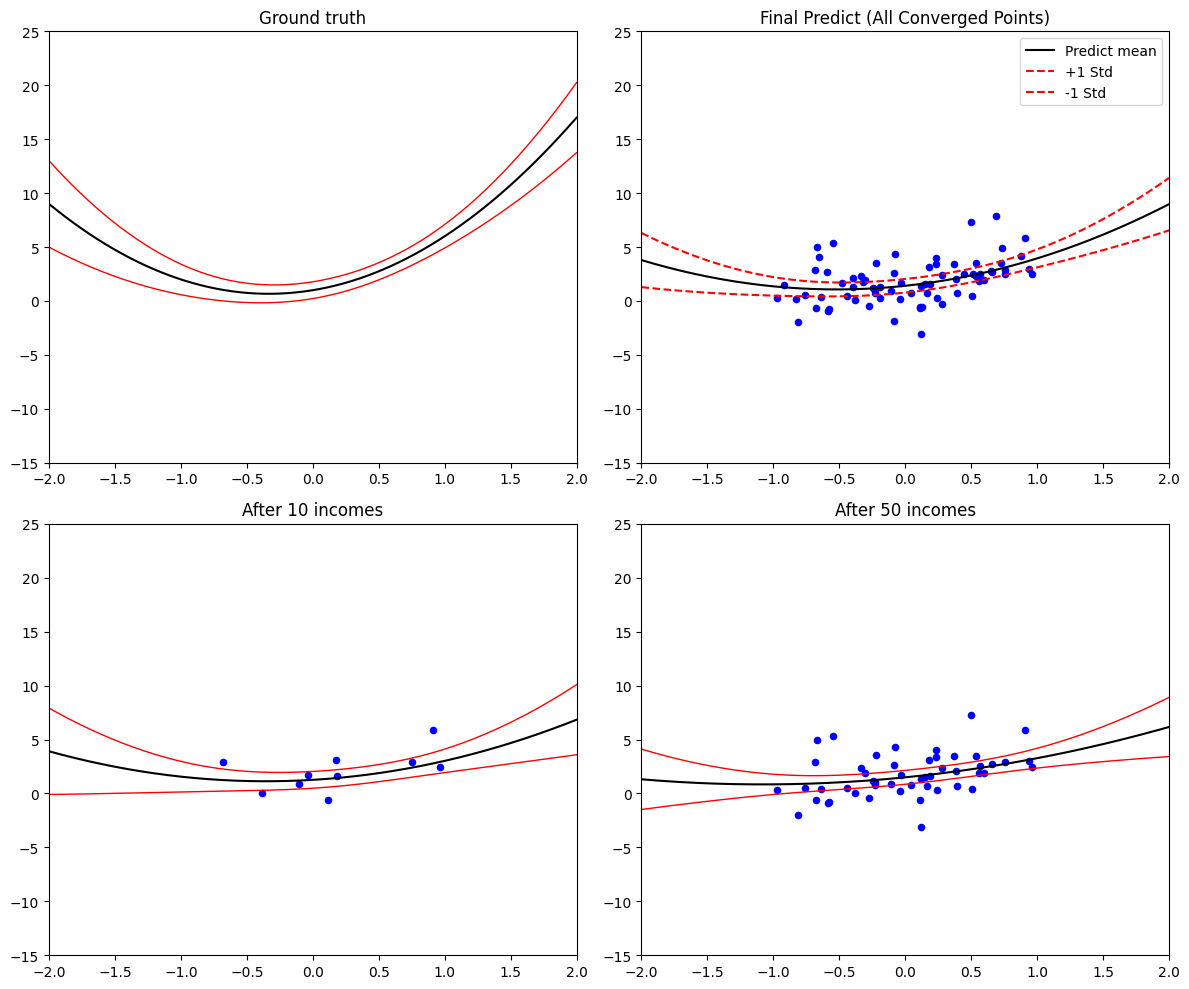

In [50]:
def plot_bayes_snapshots_with_final_convergence(snapshots, n_basis, a, w_true):
    x_plot = np.linspace(-2, 2, 200)
    true_y = [np.dot(w_true, [x**i for i in range(n_basis)]) for x in x_plot]

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    snap_10 = snapshots[10]
    pred_mean_10, pred_std_10 = predict(x_plot, snap_10["mu"], snap_10["S"], n_basis, a)

    snap_50 = snapshots[50]
    pred_mean_50, pred_std_50 = predict(x_plot, snap_50["mu"], snap_50["S"], n_basis, a)

    final_snapshot = snapshots["final"]
    pred_mean_final, pred_std_final = predict(x_plot, final_snapshot["mu"], final_snapshot["S"], n_basis, a)

    # 左上：Ground truth
    axs[0, 0].plot(x_plot, true_y, 'k', label='Ground truth')
    axs[0, 0].plot(x_plot, np.array(true_y) + pred_std_10, 'r', linewidth=1)
    axs[0, 0].plot(x_plot, np.array(true_y) - pred_std_10, 'r', linewidth=1)
    axs[0, 0].set_xlim([-2, 2])
    axs[0, 0].set_ylim([-15, 25])
    axs[0, 0].set_title("Ground truth")

    # 右上：Final predict result using all converged points
    axs[0, 1].plot(x_plot, pred_mean_final, 'k', label='Predict mean')
    axs[0, 1].plot(x_plot, pred_mean_final + pred_std_final, 'r--', label='+1 Std')
    axs[0, 1].plot(x_plot, pred_mean_final - pred_std_final, 'r--', label='-1 Std')
    axs[0, 1].scatter(final_snapshot["x_seen"], final_snapshot["y_seen"], color='blue', s=20)
    axs[0, 1].set_xlim([-2, 2])
    axs[0, 1].set_ylim([-15, 25])
    axs[0, 1].set_title("Final Predict (All Converged Points)")
    axs[0, 1].legend()

    # 左下：After 10 incomes
    axs[1, 0].plot(x_plot, pred_mean_10, 'black', label='Predict mean')
    axs[1, 0].plot(x_plot, pred_mean_10 + pred_std_10, 'r', linewidth=1)
    axs[1, 0].plot(x_plot, pred_mean_10 - pred_std_10, 'r', linewidth=1)
    axs[1, 0].scatter(snap_10["x_seen"], snap_10["y_seen"], color='blue', s=20)
    axs[1, 0].set_xlim([-2, 2])
    axs[1, 0].set_ylim([-15, 25])
    axs[1, 0].set_title("After 10 incomes")

    # 右下：After 50 incomes
    axs[1, 1].plot(x_plot, pred_mean_50, 'black', label='Predict mean')
    axs[1, 1].plot(x_plot, pred_mean_50 + pred_std_50, 'r', linewidth=1)
    axs[1, 1].plot(x_plot, pred_mean_50 - pred_std_50, 'r', linewidth=1)
    axs[1, 1].scatter(snap_50["x_seen"], snap_50["y_seen"], color='blue', s=20)
    axs[1, 1].set_xlim([-2, 2])
    axs[1, 1].set_ylim([-15, 25])
    axs[1, 1].set_title("After 50 incomes")

    plt.tight_layout()
    plt.show()

# 繪圖
plot_bayes_snapshots_with_final_convergence(temp, n_basis=n, a=a, w_true=w_true)
